# Protein background in empty droplets

Zoë Steier

* Dataset: SLN111-D1 (mouse spleen and lymph node with 111 protein panel from experiment day 1), incuding empty droplets
* Plot examples of protein background from empty droplets and non-expressing cell types
* Plot examples of protein denoising

## Imports and settings

In [1]:
# Import required packages

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc 
import anndata
import seaborn as sns
from scipy import stats

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Plotting settings

colors = ["#3B7EA1", "#FDB515", "#D9661F", "#859438", "#EE1F60", "#00A598"]
sns.set(context="notebook", font_scale=1.3, style="ticks")
sns.set_palette(sns.color_palette(colors))
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['savefig.transparent'] = True
sc.settings._vector_friendly = True
DPI = 300

## Load data

In [3]:
# Read anndata object for SLN111-D1

adata = anndata.read("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/post_adata_111day1.h5ad")

##  Load empty droplets

In [8]:
# Read all barcodes (cells and empty droplets) from h5 file into anndata object
# This data is very large, so use compressed sparse format instead of .mtx

SLN111d1_path = "/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/cellranger_out/5_B6_spl_LN_r4_111/outs/raw_feature_bc_matrix.h5"

adata_alldroplets = sc.read_10x_h5(SLN111d1_path, gex_only=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [9]:
#  Read cell barcodes from h5 file into anndata object

SLN111d1_cells_path = "/data/yosef2/users/zsteier/TotalSeq/20190814_BioLegend_ZRS08/cellranger_out/5_B6_spl_LN_r4_111/outs/filtered_feature_bc_matrix.h5"

adata_celldroplets = sc.read_10x_h5(SLN111d1_cells_path, gex_only=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [10]:
# Fill fields of anndata object (don't use .X.A - this makes it not sparse)

adata_alldroplets.obsm["protein_expression"] = adata_alldroplets[
    :, adata_alldroplets.var["feature_types"] == "Antibody Capture"
].X

adata_alldroplets.uns["protein_names"] = np.array(
    adata_alldroplets.var_names[adata_alldroplets.var["feature_types"] == "Antibody Capture"]
)
adata_alldroplets = adata_alldroplets[
    :, adata_alldroplets.var["feature_types"] != "Antibody Capture"
].copy()
adata_alldroplets.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [11]:
adata_alldroplets

AnnData object with n_obs × n_vars = 6794880 × 28692 
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [12]:
# Find which barcodes are cells and which are the empty droplets

cellbc = adata_celldroplets.obs.index
allbc = adata_alldroplets.obs.index
emptybc = np.array([bc not in cellbc for bc in allbc])

np.sum(emptybc)

6783720

In [13]:
# Filter empty droplets to those with between 20 and 100 RNA UMI counts (~80,000 droplets)
# (below 20 could be sequencing errors, and above 100 could possible have cell fragments or dead cells)

adata_empty = adata_alldroplets[emptybc, :]
sc.pp.filter_cells(adata_empty, min_counts=20)
sc.pp.filter_cells(adata_empty, max_counts=100)

adata_empty

Trying to set attribute `.obs` of view, making a copy.


AnnData object with n_obs × n_vars = 75358 × 28692 
    obs: 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'protein_names'
    obsm: 'protein_expression'

In [14]:
# Now that the data is filtered, convert from sparse to full

adata_empty.obsm["protein_expression"] = adata_empty.obsm["protein_expression"].A
adata_empty.X = adata_empty.X.A

## Barcode rank plot

In [15]:
# Make barcode rank plot to highlight empty droplets
# Find RNA UMI count per droplet

rna_umi = np.array(np.sum(adata_alldroplets.X, axis = 1))

In [118]:
# Sort UMI counts (low to high)

sorted_umis = np.sort(rna_umi, axis = None)

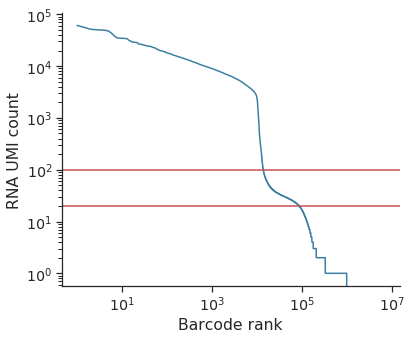

In [19]:
# Barcode rank plot
# empty droplets considered are those between the red lines

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(range(1, len(sorted_umis) + 1), sorted_umis[::-1])
ax.axhline(y = 20, color='r')
ax.axhline(y = 100, color = 'r')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set(ylabel = "RNA UMI count")
ax.set(xlabel = "Barcode rank")
sns.despine()
plt.tight_layout()

fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/barcode_rank_emptydrops.pdf", dpi=DPI, bbox_inches='tight')

## Plot background in cells and empty droplets

In [20]:
# Find matched RNA-protein names

encoded_proteins = pd.Series(adata.var["encode"][adata.var["encode"] != "None"], name = "Protein")
encoded_proteins

index
Cd28                   ADT_CD28_A0204
Icos            ADT_CD278(ICOS)_A0171
Pdcd1           ADT_CD279(PD-1)_A0004
Cxcr4          ADT_CD184(CXCR4)_A0444
Cd55              ADT_CD55(DAF)_A0558
                     ...             
Cd14                   ADT_CD14_A0424
Csf1r         ADT_CD115(CSF-1R)_A0105
Cd5                     ADT_CD5_A0111
Ms4a1                  ADT_CD20_A0192
Cd274    ADT_CD274(B7-H1_PD-L1)_A0190
Name: Protein, Length: 98, dtype: category
Categories (99, object): [ADT_CD4_A0001, ADT_CD5_A0111, ADT_CD8a_A0002, ADT_CD8b(Ly-3)_A0230, ..., ADT_anti-P2RY12_A0415, ADT_integrinb7_A0214, HTO_B6_spl_r4_206_A0302, None]

In [21]:
# Cell type labels

# B cells
bcells = np.array([
    c in ["1", "3", "4", "5", "7", "8", "9", "11", "13"]
    for c in adata.obs["leiden_subclusters"]
])

# CD4 T cells
cd4tcells = np.array([
    c in ["0", "14", "27", "10,0", "10,1"]
    for c in adata.obs["leiden_subclusters"]
])

# Treg
treg = np.array([
    c in ["10,0", "10,1"]
    for c in adata.obs["leiden_subclusters"]
])

# All T cells
tcells = np.array([
    c in ["0", "14", "27", "10,0", "10,1", # CD4
         "2", "6", "18"] # CD8
    for c in adata.obs["leiden_subclusters"]
])

# CD8 T cells
cd8tcells = np.array([
    c in ["2", "6", "18"]
    for c in adata.obs["leiden_subclusters"]
])

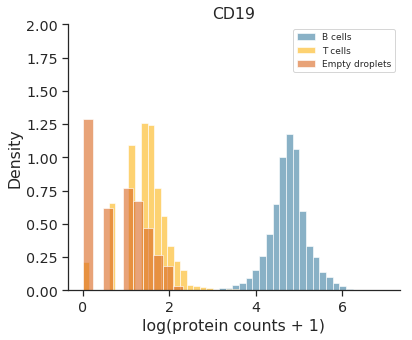

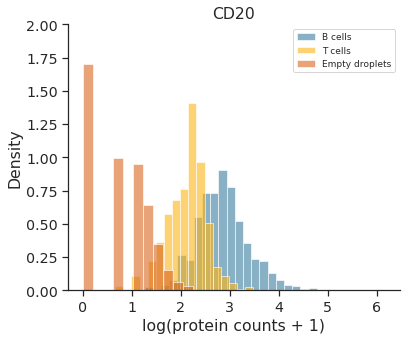

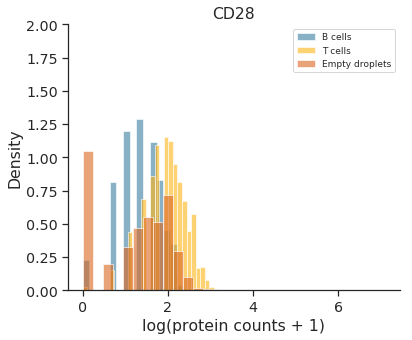

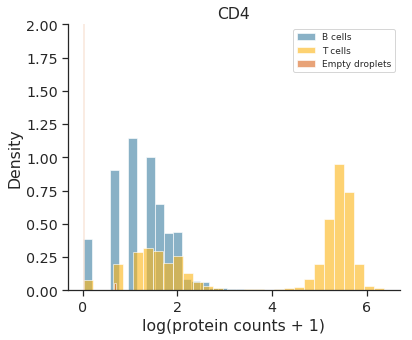

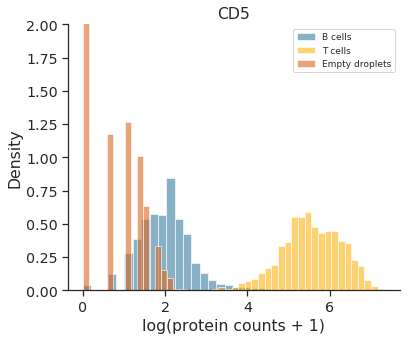

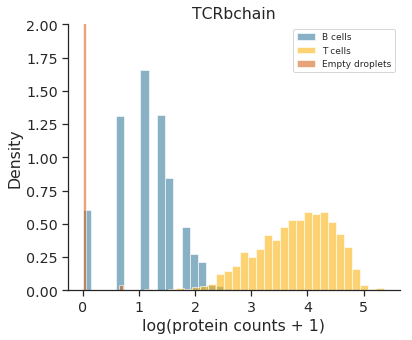

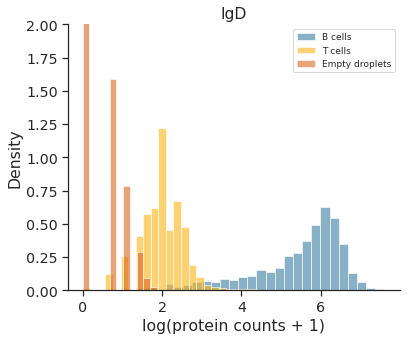

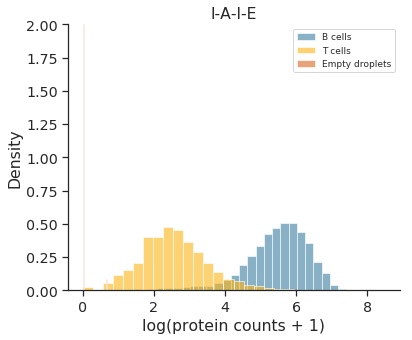

In [22]:
# Plot distribution of protein counts in cells and empty droplets
# Compare B cells and T cells for example proteins

for RNA_name in ["Cd19", "Ms4a1", "Cd28", "Cd4", "Cd5", "Trbc1", "Ighd", "H2-Aa"]:
    fig, ax = plt.subplots(figsize=(6, 5))
    num_bins = 30
    protein = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]

    # B cells
    ax.hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][bcells]), 
            bins = num_bins,
            alpha = 0.6,
            density = True, 
            color = colors[0],
            label = "B cells"
              )
    
    # T cells
    ax.hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][tcells]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[1],
        label = "T cells"
          )
    
    # empty droplets
    ax.hist(np.log1p(adata_empty.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[2],
        label = "Empty droplets"
          )
    
    ax.set_ylim((0, 2)) # truncate y-axis at 2 for clarity
    plt.legend(loc='upper right', prop={'size': 9})

    ax.set(ylabel = "Density")
    ax.set(xlabel = "log(protein counts + 1)")
    protein_title = protein.split("_")[1].split("(")[0]
    ax.set_title(protein_title)
    sns.despine()
    plt.tight_layout()

    fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/EmptyDrops_%s.pdf" % RNA_name, dpi=DPI, bbox_inches='tight')

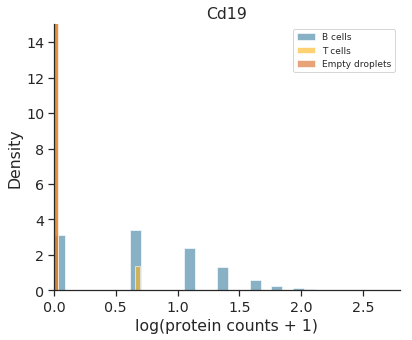

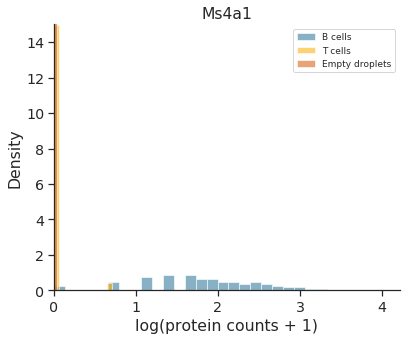

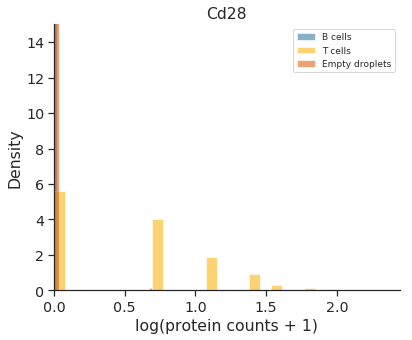

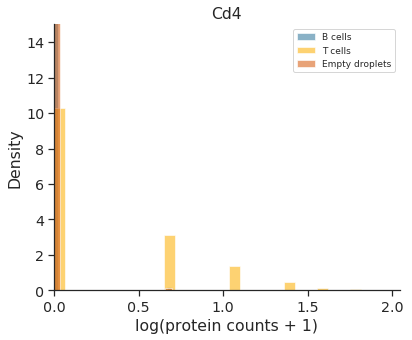

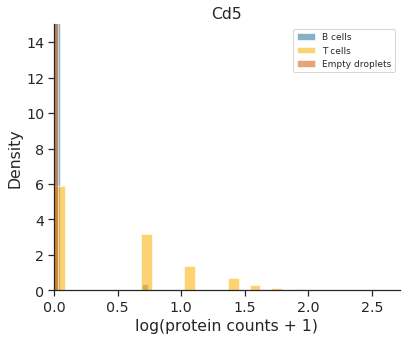

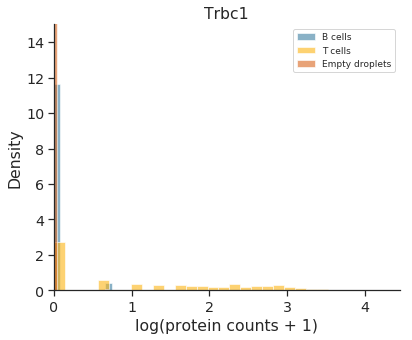

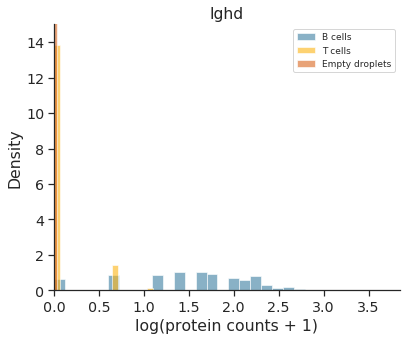

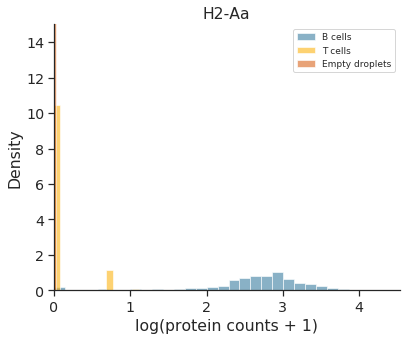

In [23]:
# Plot distribution of RNA counts in cells and empty droplets
# Compare B cells and T cells

for RNA_name in ["Cd19", "Ms4a1", "Cd28", "Cd4", "Cd5", "Trbc1", "Ighd", "H2-Aa"]:
    fig, ax = plt.subplots(figsize=(6, 5))
    num_bins = 30

    # B cells
    ax.hist(np.log1p(adata.X[:, np.where(adata.uns["totalVI_genes"] == RNA_name)[0][0]][bcells]), 
            bins = num_bins,
            alpha = 0.6,
            density = True, 
            color = colors[0],
            label = "B cells"
              )
    
    # T cells
    ax.hist(np.log1p(adata.X[:, np.where(adata.uns["totalVI_genes"] == RNA_name)[0][0]][tcells]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[1],
        label = "T cells"
          )
    
    # Empty droplets
    ax.hist(np.log1p(adata_empty.X[:, np.where(adata.uns["totalVI_genes"] == RNA_name)[0][0]]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[2],
        label = "Empty droplets"
          )
    ax.set_ylim((0, 15))
    ax.set_xlim(left = 0)
    plt.legend(loc='upper right', prop={'size': 9})

    ax.set(ylabel = "Density")
    ax.set(xlabel = "log(protein counts + 1)")
    protein_title = protein.split("_")[1].split("(")[0]
    ax.set_title(RNA_name)
    sns.despine()
    plt.tight_layout()

# Empty droplets are almost entirely zero for RNA background

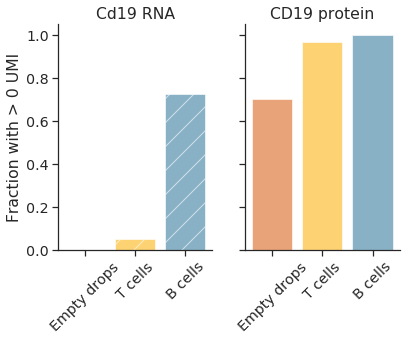

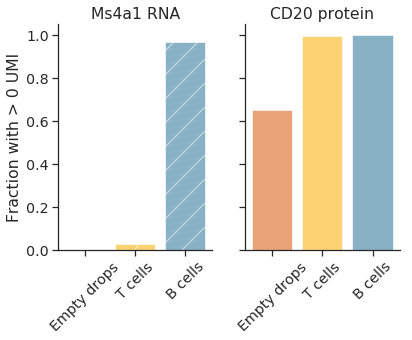

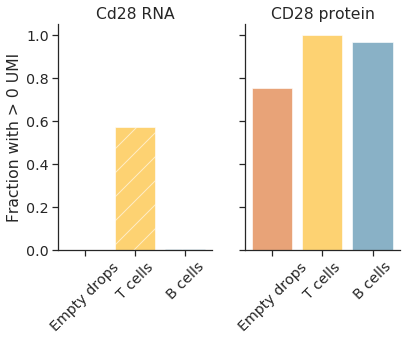

In [24]:
# Bar plot fraction of cells where the protein or RNA is detected

for RNA_name in ["Cd19", "Ms4a1", "Cd28"]:
    protein = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]    
        
    fig, ax = plt.subplots(1, 2, figsize=(6, 5), sharey = True)
    
    # RNA
    x = np.arange(3)
    emptyexpress_rna = np.sum((adata_empty.X[:, np.where(adata.uns["totalVI_genes"] == RNA_name)[0][0]]) > 0)/adata_empty.X.shape[0]
    Texpress_rna = np.sum((adata.X[:, np.where(adata.uns["totalVI_genes"] == RNA_name)[0][0]][tcells]) > 0)/np.sum(tcells)
    Bexpress_rna = np.sum((adata.X[:, np.where(adata.uns["totalVI_genes"] == RNA_name)[0][0]][bcells]) > 0)/np.sum(bcells)

    percent_expressed_rna = [emptyexpress_rna, Texpress_rna, Bexpress_rna]

    ax[0].bar(x, percent_expressed_rna, 
           tick_label = ("Empty drops", "T cells", "B cells"),
          color = (colors[2], colors[1], colors[0]),
          alpha = 0.6,
             hatch = "/")
    sns.despine()
    ax[0].set(ylabel = "Fraction with > 0 UMI")
    ax[0].set(title = RNA_name + " RNA")
    ax[0].xaxis.set_tick_params(rotation=45)

    
    # Protein
    x = np.arange(3)
    emptyexpress = np.sum((adata_empty.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]]) > 0)/adata_empty.X.shape[0]
    Texpress = np.sum((adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][tcells]) > 0)/np.sum(tcells)
    Bexpress = np.sum((adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][bcells]) > 0)/np.sum(bcells)

    percent_expressed = [emptyexpress, Texpress, Bexpress]

    ax[1].bar(x, percent_expressed, 
           tick_label = ("Empty drops", "T cells", "B cells"),
          color = (colors[2], colors[1], colors[0]),
          alpha = 0.6)
    sns.despine()
    protein_abbrev = protein.split("_")[1].split("(")[0]

    ax[1].set(title = protein_abbrev + " protein")
    ax[1].xaxis.set_tick_params(rotation=45)
    
    plt.tight_layout()
    
    fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/EmptyDrops_bar_%s.pdf" % RNA_name, dpi=DPI, bbox_inches='tight')

## Distributions of raw and denoised proteins

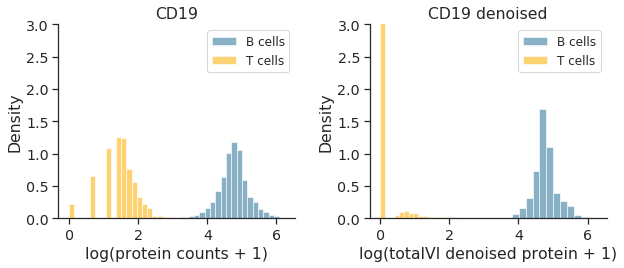

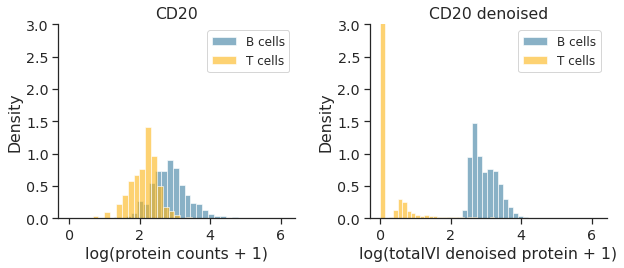

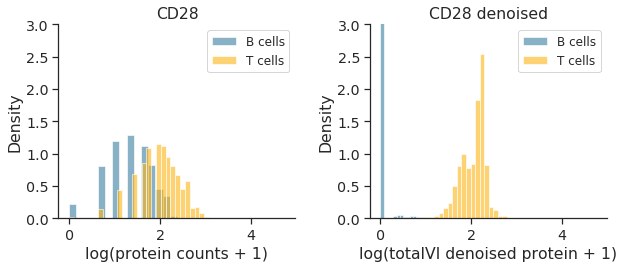

In [262]:
# Plot histograms of raw vs denoised expression in B cells and T cells for a few example proteins

for RNA_name in ["Cd19", "Ms4a1", "Cd28"]:
    fig, ax = plt.subplots(1, 2, figsize=(9, 4), sharex = True, )
    num_bins = 30
    protein = encoded_proteins[np.where(encoded_proteins.index == RNA_name)[0][0]]
    
    # Plot raw proteins (log(counts + 1))
    
    # B cells
    ax[0].hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][bcells]), 
            bins = num_bins,
            alpha = 0.6,
            density = True, 
            color = colors[0],
            label = "B cells"
              )
    # T cells
    ax[0].hist(np.log1p(adata.obsm["protein_expression"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][tcells]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[1],
        label = "T cells"
          )
    
    ax[0].legend(loc='upper right', prop={'size': 12})
    ax[0].set(ylabel = "Density")
    ax[0].set(xlabel = "log(protein counts + 1)")
    protein_title = protein.split("_")[1].split("(")[0]
    ax[0].set_title(protein_title)
    ax[0].set_ylim((0, 3)) # truncate at 3 for clarity

    
    # Plot denoised proteins (log(denoised + 1))
    
    # B cells
    ax[1].hist(np.log1p(adata.obsm["denoised_proteins"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][bcells]), 
            bins = num_bins,
            alpha = 0.6,
            density = True, 
            color = colors[0],
            label = "B cells"
              )
    # T cells
    ax[1].hist(np.log1p(adata.obsm["denoised_proteins"][:, np.where(adata.uns["totalVI_proteins"] == protein)[0][0]][tcells]), 
        bins = num_bins,
        alpha = 0.6,
        density = True, 
        color = colors[1],
        label = "T cells"
          )

    ax[1].legend(loc='upper right', prop={'size': 12})
    ax[1].set(ylabel = "Density")
    ax[1].set(xlabel = "log(totalVI denoised protein + 1)")
    protein_title = protein.split("_")[1].split("(")[0]
    ax[1].set_title(protein_title + " denoised")
    ax[1].set_ylim((0, 3)) # truncate at 3 for clarity
  
    
    sns.despine()
    plt.tight_layout()

    fig.savefig("/data/yosef2/users/zsteier/totalVI/totalVI_journal/background/background_figs_111day1/Denoised_BT_%s_histogram.pdf" % protein_title, dpi=DPI, bbox_inches='tight')